In [1]:
# !pip install grpcio==1.42.0 tensorflow-serving-api==2.7.0

  Using cached grpcio-1.42.0-cp39-cp39-win_amd64.whl (3.3 MB)
  Using cached tensorflow_serving_api-2.7.0-py2.py3-none-any.whl (37 kB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.46.3
    Uninstalling grpcio-1.46.3:
      Successfully uninstalled grpcio-1.46.3


In [7]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = keras.sum(keras.abs(y_true * y_pred))
    sum_ = keras.sum(keras.square(y_true)) + keras.sum(keras.square(y_pred))
    jac = (intersection) / (sum_ - intersection)
    return jac

In [5]:
model = tf.keras.models.load_model('./unet_lung_seg.hdf5', 
                                   custom_objects={'dice_coef': dice_coef,'dice_coef_loss': dice_coef_loss, 'iou':iou})

In [6]:
model

In [196]:
tf.saved_model.save(model, 'unet_lung_model')

INFO:tensorflow:Assets written to: unet_lung_model\assets


INFO:tensorflow:Assets written to: unet_lung_model\assets


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 32  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_4 (Dropout)            (None, 64, 64, 512)  0           ['concatenate[0][0]']            
                                                                                                  
 conv2d_10 (Conv2D)             (None, 64, 64, 256)  1179904     ['dropout_4[0][0]']              
                                                                                                  
 activation_10 (Activation)     (None, 64, 64, 256)  0           ['conv2d_10[0][0]']              
                                                                                                  
 conv2d_11 (Conv2D)             (None, 64, 64, 256)  590080      ['activation_10[0][0]']          
                                                                                                  
 activation_11 (Activation)     (None, 64, 64, 256)  0           ['conv2d_11[0][0]']              
          

In [9]:
image = cv2.imread('seg_test_r/CHNCXR_0300_0.png')
mask_image = cv2.imread('seg_test_r/CHNCXR_0300_0_mask.png', cv2.IMREAD_GRAYSCALE)

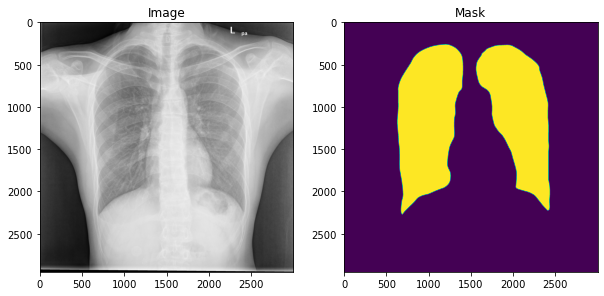

In [179]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title("Image")
axs[0].imshow(image)
axs[1].set_title("Mask")
axs[1].imshow(mask_image)

In [66]:
def add_colored_mask(image, mask_image):
    mask_image_color = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2BGR)
    mask = cv2.bitwise_and(mask_image_color, mask_image_color, mask=mask_image)
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)
    return ret

def load_image(img_file, target_size=(256,256)):
    img_gray = cv2.cvtColor(img_file, cv2.COLOR_BGR2GRAY)
#     img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    img = img_gray / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

In [12]:
# img = test_load_image('seg_test_r/CHNCXR_0300_0.png', target_size=(512,512))
img = load_image(image, target_size=(512,512))
img.shape

(1, 512, 512, 1)

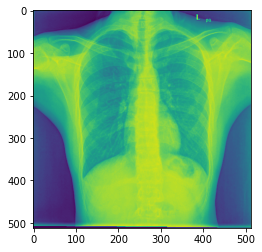

In [190]:
plt.imshow(img[0])

In [191]:
pred = model.predict(img)

1/1 [==============================] - 1s 1s/step


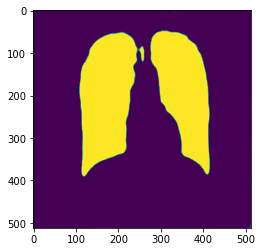

In [192]:
plt.imshow(pred[0])

In [ ]:
def show_pred(image, pred):
    pred_cvt = (pred[0][:, :, 0] * 255.).astype(np.uint8)

In [117]:
pred_1 = (pred[0][:, :, 0] * 255.).astype(np.uint8)

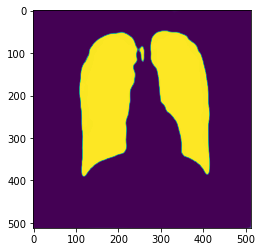

In [120]:
plt.imshow(pred_1)

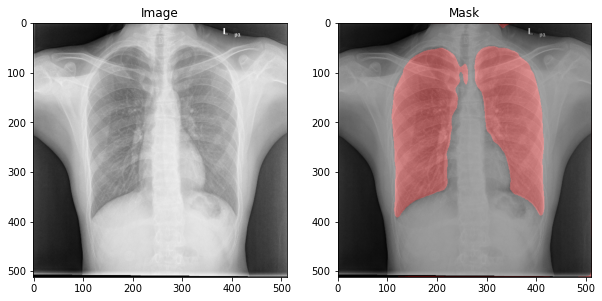

In [185]:
image_test = cv2.imread('seg_test/CHNCXR_0300_0.png')
mask_image_test = cv2.imread('seg_test/CHNCXR_0300_0_mask.png')

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Image")
axs[0].imshow(image_test)
axs[1].set_title("Mask")
axs[1].imshow(add_colored_mask_single_channel(image_test, pred_1.reshape(512,512)))

In [193]:
# import urllib.request
# import numpy as np

# url = 'http://bit.ly/mlbookcamp-pants'

# with urllib.request.urlopen(url) as url:
#     img_array = np.asarray(bytearray(url.read()), dtype=np.uint8)
#     img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

In [2]:
import grpc

import tensorflow as tf

from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc

In [4]:
host = 'localhost:8500'

channel = grpc.insecure_channel(host)

stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

In [5]:
def np_to_protobuf(data):
    return tf.make_tensor_proto(data, shape=data.shape)

In [45]:
pb_request = predict_pb2.PredictRequest()

pb_request.model_spec.name = 'unet_lung_model'
pb_request.model_spec.signature_name = 'serving_default'

pb_request.inputs['input_1'].CopyFrom(np_to_protobuf(img.astype(np.float32)))
pb_response = stub.Predict(pb_request, timeout=20.0)
preds = pb_response.outputs['conv2d_18'].float_val
# preds = pb_response.outputs['conv2d_18']

In [103]:
pred_arr = np.array(list(preds))

In [104]:
pred_arr = np.reshape(pred_arr, (512, 512))

In [105]:
pred_arr.shape

(512, 512)

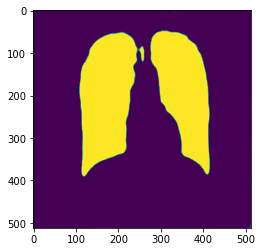

In [106]:
plt.imshow(pred_arr)

In [107]:
image_test.shape, pred_arr.shape

((512, 512, 3), (512, 512))

In [111]:
pred_1 = (pred_arr * 255.).astype(np.uint8)

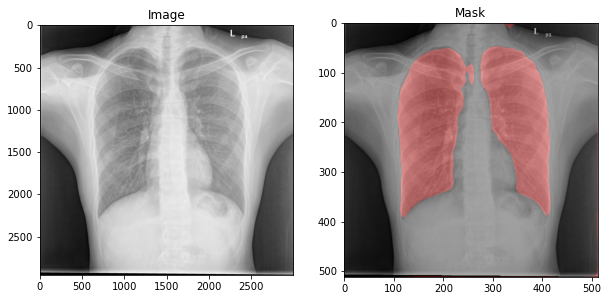

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
image_test = cv2.resize(image, (512,512))

axs[0].set_title("Image")
axs[0].imshow(image)
axs[1].set_title("Mask")
axs[1].imshow(add_colored_mask(image_test, pred_1))
plt.show()

## Send Prediction

In [204]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": img.tolist()})

In [ ]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8500/v1/models/unet-lung-model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']
predictions

In [206]:
import requests

url = 'http://localhost:8500/v1/models/unet-lung-model/1:predict'

data = {'instances': img}

result = requests.post(url, json=data)
print(result)

TypeError: Object of type ndarray is not JSON serializable